# Part 2.1: Transition Matrices and Markov Chains

Welcome to Part 2.1 of our Reinforcement Learning tutorial series! This notebook introduces the mathematical foundations we'll need to understand MDPs - starting with the most fundamental building block: transition matrices and Markov chains.

## Recap from Part 1

In Part 1 (Foundations of RL), we covered:
- The agent-environment interaction loop and how RL agents learn through trial and error
- The Markov property: the future depends only on the present state, not the full history
- Value functions V(s) and Q(s,a) that quantify how "good" states and actions are
- The discount factor γ that makes sooner rewards more valuable than distant ones
- Models of the environment (transitions P and rewards R) vs model-free learning

## Preview

Now we'll formalize these concepts mathematically. We start with **transition matrices** - the mathematical representation of "where can I go from here?" This foundation will lead us through Markov Reward Processes (Part 2.2) to full Markov Decision Processes (Part 2.3), building up the complete mathematical framework for RL.

## What This Notebook Covers
- Transition probability matrices and how they describe state evolution
- Markov processes (Markov chains) and the Markov property
- Simulating random walks on Markov chains
- Building transition matrices from environments like FrozenLake

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Rewards** | Markov chains model state evolution only. Rewards come in Part 2.2 (MRPs). | We focus on *where you can go* (transitions between states). MRPs add *how valuable each state is* (rewards), letting us evaluate "good" vs "bad" states. |
| **Actions and decision-making** | Markov chains have no actions - transitions happen automatically. Actions come in Part 2.3 (MDPs). | Here, state evolution is predetermined by fixed transition probabilities. MDPs give the agent *choices* - the agent actively decides which action to take, fundamentally changing from passive observation to active control. |
| **Deep RL** | We use tabular methods with discrete states. Deep RL uses neural networks for large/continuous state spaces. | Our 16-state FrozenLake has a 16×16 transition matrix we can store exactly. Deep RL handles millions of states (images, sensor data) using neural networks to approximate transition dynamics - adding significant complexity. |

## Prerequisites
- Completed Part 1 (Foundations of RL)
- Basic linear algebra (matrix multiplication)
- Basic probability (conditional probability, probability distributions)

## How to Read This Notebook
1. **Start with the transition matrix section** - Understanding how to read these matrices is crucial
2. **See the concepts in code** - We build transition matrices for FrozenLake
3. **Visualize state evolution** - Heatmaps and simulations make the math concrete
4. **Use checkpoints** - Verify your understanding before moving on

Let's begin!

---
## Setup

First, let's import the necessary libraries and set up our environment.

> **Note:** If you're running this in a fresh environment (like Google Colab or a new virtualenv), uncomment and run the installation cell below first.

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    return fig, ax


def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualize the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    im = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

---
# 1. Understanding Transition Matrices (Foundation)

Before we dive into Markov Processes and MDPs, let's first understand a fundamental building block: the **transition probability matrix**. This concept appears throughout reinforcement learning, so grasping it now will make everything else much clearer!

## What is a Transition Matrix?

A **transition matrix** $P$ describes how an agent (or system) moves between states. It's organized as a table:

- **Rows** represent the **current state** $s$
- **Columns** represent the **next state** $s'$
- **Entry** $P_{ss'}$ = probability of going from state $s$ to state $s'$

### Example with 3 States

Suppose we have 3 states: {0, 1, 2}. The transition matrix looks like:

$$P = \begin{bmatrix}
P_{00} & P_{01} & P_{02} \\
P_{10} & P_{11} & P_{12} \\
P_{20} & P_{21} & P_{22}
\end{bmatrix}
= \begin{bmatrix}
P(0 \to 0) & P(0 \to 1) & P(0 \to 2) \\
P(1 \to 0) & P(1 \to 1) & P(1 \to 2) \\
P(2 \to 0) & P(2 \to 1) & P(2 \to 2)
\end{bmatrix}$$

### How to Read the Matrix

**Rule:** To find the probability of going from state $i$ to state $j$, look at **row $i$, column $j$**.

- **Row 0** shows all transitions **from** state 0: where can I go from state 0?
- **Row 1** shows all transitions **from** state 1: where can I go from state 1?
- **Row 2** shows all transitions **from** state 2: where can I go from state 2?

### Concrete Example

$$P = \begin{bmatrix}
0.5 & 0.3 & 0.2 \\
0.1 & 0.7 & 0.2 \\
0.0 & 0.4 & 0.6
\end{bmatrix}$$

**Reading this matrix:**

**From state 0 (row 0):**
- 50% chance to stay in state 0 ($P_{00} = 0.5$)
- 30% chance to go to state 1 ($P_{01} = 0.3$)
- 20% chance to go to state 2 ($P_{02} = 0.2$)
- **Row sum:** $0.5 + 0.3 + 0.2 = 1.0$ ✓

**From state 1 (row 1):**
- 10% chance to go to state 0 ($P_{10} = 0.1$)
- 70% chance to stay in state 1 ($P_{11} = 0.7$)
- 20% chance to go to state 2 ($P_{12} = 0.2$)
- **Row sum:** $0.1 + 0.7 + 0.2 = 1.0$ ✓

**From state 2 (row 2):**
- 0% chance to go to state 0 ($P_{20} = 0.0$) - impossible!
- 40% chance to go to state 1 ($P_{21} = 0.4$)
- 60% chance to stay in state 2 ($P_{22} = 0.6$)
- **Row sum:** $0.0 + 0.4 + 0.6 = 1.0$ ✓

## Why Must Each Row Sum to 1?

Each row represents **all possible next states** from a given current state. Since the agent **must** end up in *some* state at the next time step, the probabilities must sum to 1 (100%).

This is called a **stochastic matrix** or **row-stochastic matrix**.

## Key Notation

You'll see this notation throughout the notebook:

- $P_{ss'}$ = probability of transitioning from state $s$ to state $s'$ (read as "P sub s s-prime")
- $P[S_{t+1} = s' | S_t = s]$ = the same thing in probability notation ("probability that next state is s-prime given current state is s")
- $s$ = current state (typically the row)
- $s'$ = next state (typically the column, the prime ' means "next")

## FrozenLake Preview

For FrozenLake with 16 states, the transition matrix will be **16×16**:
- 16 rows (one for each current state)
- 16 columns (one for each possible next state)
- 256 total entries (though many will be 0 since not all transitions are possible)

Now that you understand transition matrices, let's see how they're used in Markov Processes!

---
# 2. Markov Processes (Markov Chains)

Now that you understand transition matrices, let's see how they're used! A **Markov Process** (also called a Markov Chain) is the simplest model of sequential state transitions.

## Definition

A **Markov Process** is a tuple $(S, P)$ where:
- $S$ is a finite set of states
- $P$ is a **state transition probability matrix**: $P_{ss'} = P[S_{t+1} = s' | S_t = s]$

**Plain English:** "The probability of transitioning from state s to state s-prime equals the probability that the next state is s-prime, given that the current state is s."

**Formula components:**
- $P_{ss'}$ = the transition probability from state $s$ to state $s'$ (read as "P sub s s-prime")
- $P[\cdot]$ = probability of the event in brackets
- $S_{t+1}$ = the state random variable at the next time step
- $s'$ = a specific next state value (the prime ' indicates "next")
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific current state value

The Markov Process describes a random walk through states, where the next state depends **only on the current state** (the Markov property we learned in Notebook 1.1).

## Key Properties

| Property | Description |
|----------|-------------|
| **No actions** | The agent doesn't make decisions - transitions happen automatically |
| **No rewards** | We only track which states we visit, not how "good" they are |
| **Memoryless** | Future states depend only on the current state, not history |
| **Stochastic** | Transitions are probabilistic. Each row of the matrix $P$ represents all possible transitions from one state, and must sum to 1 (as explained in Section 1) |

## FrozenLake as a Markov Process

If we take FrozenLake and fix a policy (say, uniform random), the agent no longer makes decisions - it just follows the policy automatically. Since FrozenLake has no rewards in a pure Markov Process view, this gives us a **Markov Process** (we ignore rewards for now).

- **States**: The 16 positions on the grid (0-15)
- **Transitions**: Determined by the fixed policy + slippery ice dynamics
- **Matrix size**: 16×16 (16 states, so 16 rows and 16 columns)

In [4]:
# Create FrozenLake environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env.reset(seed=42)

print("FrozenLake with Random Policy = Markov Process")
print("=" * 50)
print(f"\nStates S: {{{', '.join(map(str, range(16)))}}}")
print(f"Number of states |S|: {env.observation_space.n}")
print("\nWith a fixed random policy, the agent doesn't choose -")
print("it just follows the policy, creating a Markov Chain.")

FrozenLake with Random Policy = Markov Process

States S: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Number of states |S|: 16

With a fixed random policy, the agent doesn't choose -
it just follows the policy, creating a Markov Chain.


### 🔍 About the Code Below

In the next code cells, we'll use `env.unwrapped.P` to **peek inside** FrozenLake's internal model. This is **instructor-only knowledge** for educational purposes.

**Remember: A real RL agent does NOT have access to this information!** 

The agent would need to learn the transition probabilities and rewards through trial and error by interacting with the environment. We're using `env.unwrapped.P` here to:
- Understand the theoretical concepts
- Verify our calculations
- Visualize the true structure of the MDP

In later notebooks, you'll see how agents learn these dynamics without access to the model.


In [5]:
# Build the transition matrix P for FrozenLake under a uniform random policy
def build_markov_chain_matrix(env):
    """
    Build transition matrix P for FrozenLake with uniform random policy.
    P[s, s'] = probability of going from state s to state s'
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Under uniform random policy, each action has probability 1/n_actions
    policy_prob = 1.0 / n_actions
    
    # Initialize transition matrix
    P = np.zeros((n_states, n_states))
    
    # For each state and action, accumulate transition probabilities
    for state in range(n_states):
        for action in range(n_actions):
            # Get transitions for this state-action pair
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                # Weight by policy probability
                P[state, next_state] += policy_prob * prob
    
    return P

P_chain = build_markov_chain_matrix(env)

print("Transition Matrix P (Markov Chain under Random Policy)")
print("=" * 55)
print(f"\nShape: {P_chain.shape} (16 states × 16 states)")
print(f"Row sums (should all be 1.0): {P_chain.sum(axis=1)[:4]}... (first 4 shown)")
print("\nTransition probabilities FROM state 0 (Start):")
for next_s in range(16):
    if P_chain[0, next_s] > 0:
        print(f"  P(0 → {next_s}) = {P_chain[0, next_s]:.4f}")

Transition Matrix P (Markov Chain under Random Policy)

Shape: (16, 16) (16 states × 16 states)
Row sums (should all be 1.0): [1. 1. 1. 1.]... (first 4 shown)

Transition probabilities FROM state 0 (Start):
  P(0 → 0) = 0.5000
  P(0 → 1) = 0.2500
  P(0 → 4) = 0.2500


**Question this plot answers:** 'What are the transition probabilities between all states?'



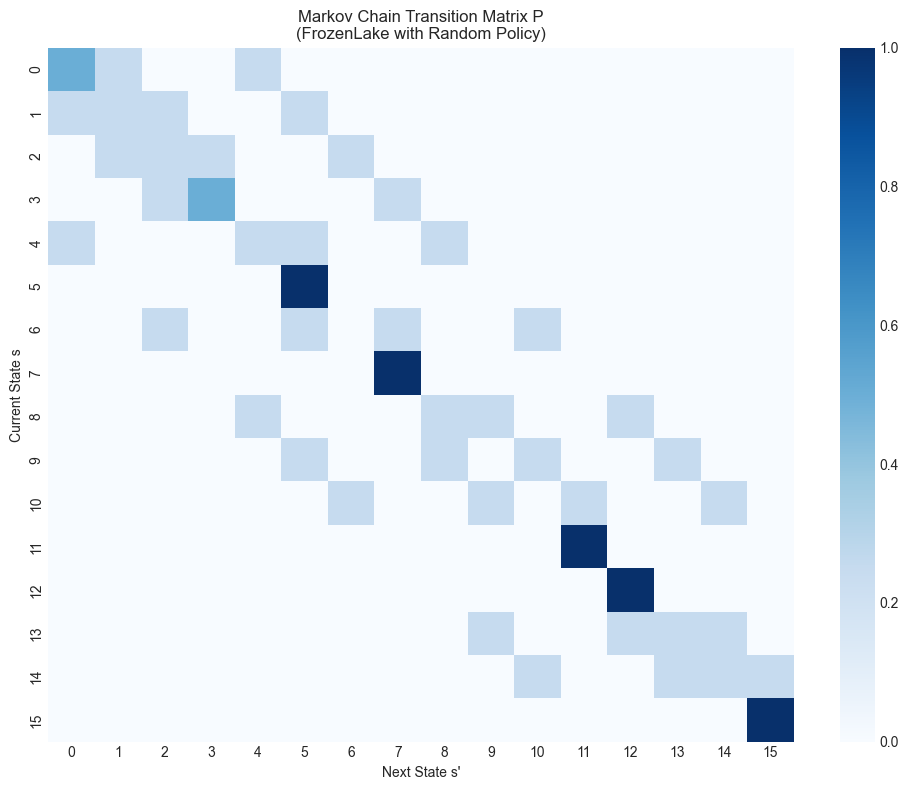

Notice: Terminal states (5, 7, 11, 12 = Holes, 15 = Goal) have self-loops
(probability 1.0 of staying in the same state).


In [6]:
# Visualize the transition matrix as a heatmap
print("**Question this plot answers:** 'What are the transition probabilities between all states?'\n")

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(P_chain, annot=False, cmap='Blues', ax=ax,
            xticklabels=range(16), yticklabels=range(16))
ax.set_xlabel('Next State s\'')
ax.set_ylabel('Current State s')
ax.set_title('Markov Chain Transition Matrix P\n(FrozenLake with Random Policy)')
plt.tight_layout()
plt.show()

print("Notice: Terminal states (5, 7, 11, 12 = Holes, 15 = Goal) have self-loops")
print("(probability 1.0 of staying in the same state).")

## Understanding the Transition Matrix Heatmap

Let's interpret what this visualization is showing us!

### The Diagonal Pattern

**Why do we see a clear pattern along the diagonal from top-left to bottom-right?**

The **dark blue spots on the diagonal** represent **self-loops** - states transitioning to themselves. Here's why this pattern appears:

1. **Terminal states have strong self-loops**:
   - **Holes** (states 5, 7, 11, 12) and **Goal** (state 15) are terminal
   - Once you reach a terminal state, you stay there forever (probability = 1.0)
   - This creates **dark blue spots** at positions (5,5), (7,7), (11,11), (12,12), and (15,15)

2. **Non-terminal states can stay in place**:
   - Due to slippery ice, even non-terminal states have a chance of staying put
   - When the agent tries to move but slips into a wall, it stays in the same state
   - Example: State 0 (top-left corner) has ~50% chance of staying at state 0

### How to Read This Heatmap

**Each row shows where you can go FROM a given state:**

- **X-axis (horizontal)**: Next state $s'$ (where you end up)
- **Y-axis (vertical)**: Current state $s$ (where you start)
- **Color intensity**: Probability of transition
  - **Bright/dark blue** = high probability (close to 1.0)
  - **Light blue/white** = low probability (close to 0.0)

**To find the transition probability from state $i$ to state $j$:**
- Look at **row $i$** (current state)
- Find **column $j$** (next state)
- The color intensity shows $P(s'=j | s=i)$

### Specific Observations

Let's examine some interesting patterns:

**Row 0 (Start state):**
- Darkest blue at column 0 (high chance of staying at start due to walls)
- Some blue at columns 1 and 4 (can move right or down)
- White/light everywhere else (zero probability to distant states - can't teleport!)

**Rows 5, 7, 11, 12, 15 (Terminal states):**
- Only dark blue at their own diagonal position
- White/light everywhere else
- These are **absorbing states** with $P(s|s) = 1.0$

**Sparse pattern overall:**
- Most of the matrix is **white/light blue** (probability ≈ 0)
- Only a few bright blue spots in each row
- This makes sense: from any state, you can only reach a **small number of nearby states**
- The grid structure limits transitions to adjacent cells

**Why is most of the matrix white (empty)?**
- FrozenLake is a **grid world** where you can only move to adjacent cells
- From state 6 (middle of grid), you can't reach state 15 (goal) in one step
- The slippery ice means from any non-terminal state, you can reach at most 3-4 different next states
- Out of 16 possible next states, only 3-4 have non-zero probability (blue)
- The other 12-13 states are impossible to reach in one step (white)

### Key Insight

This sparse structure (most entries are 0) is common in RL:
- **Grid worlds**: Can only reach nearby states
- **Board games**: Moves have limited reach
- **Robotics**: Physical constraints limit state transitions

Algorithms exploit this sparsity for efficiency - we don't need to store or compute the zero entries!

> **Visual tip:** Terminal states are easy to spot in the heatmap - they have a single dark blue spot on the diagonal and are white everywhere else.


In [7]:
# Simulate random walks on the Markov Chain
def simulate_markov_chain(P, start_state, max_steps=50):
    """Simulate a trajectory through the Markov Chain."""
    trajectory = [start_state]
    current = start_state
    terminal_states = {5, 7, 11, 12, 15}  # Holes and Goal
    
    for _ in range(max_steps):
        if current in terminal_states:
            break
        # Sample next state according to transition probabilities
        next_state = np.random.choice(len(P), p=P[current])
        trajectory.append(next_state)
        current = next_state
    
    return trajectory

# Simulate several episodes
np.random.seed(42)
print("Sample Trajectories through Markov Chain (starting from state 0)")
print("=" * 60)

for episode in range(5):
    traj = simulate_markov_chain(P_chain, start_state=0)
    final_state = traj[-1]
    outcome = "Goal!" if final_state == 15 else f"Hole at {final_state}" if final_state in {5,7,11,12} else "Timeout"
    print(f"\nEpisode {episode + 1}: {' → '.join(map(str, traj))}")
    print(f"   Outcome: {outcome} ({len(traj)} steps)")

Sample Trajectories through Markov Chain (starting from state 0)

Episode 1: 0 → 0 → 4 → 5
   Outcome: Hole at 5 (4 steps)

Episode 2: 0 → 1 → 0 → 0 → 0 → 4 → 5
   Outcome: Hole at 5 (7 steps)

Episode 3: 0 → 1 → 0 → 4 → 8 → 4 → 0 → 0 → 0 → 1 → 1 → 1 → 2 → 1 → 1 → 1 → 1 → 5
   Outcome: Hole at 5 (18 steps)

Episode 4: 0 → 0 → 1 → 2 → 1 → 2 → 1 → 0 → 4 → 8 → 12
   Outcome: Hole at 12 (11 steps)

Episode 5: 0 → 0 → 0 → 1 → 1 → 0 → 0 → 0 → 4 → 4 → 5
   Outcome: Hole at 5 (11 steps)


> **Checkpoint — You should now understand:**
> - A Markov Process (Markov Chain) is defined by states $S$ and transitions $P$
> - With a fixed policy, an MDP becomes a Markov Chain
> - The transition matrix $P$ captures all state-to-state probabilities where each row of $P$ sums to 1 (we must go somewhere)

---
# 3. Summary and Concept Map

Let's visualize the concepts we've learned:

```
MARKOV CHAINS (MARKOV PROCESSES)
=================================

Components:
  • States (S): All possible positions/situations
  • Transitions (P): Probability matrix showing state evolution

Structure:
  State s  ──P(s'|s)──>  State s'
     │                      │
     │    (probabilistic)   │
     │                      │
     └──────────────────────┘
       Time step t → t+1

Transition Matrix P:
  ┌                              ┐
  │ P(0→0)  P(0→1)  ...  P(0→n) │  ← From state 0
  │ P(1→0)  P(1→1)  ...  P(1→n) │  ← From state 1
  │   ...     ...    ...   ...  │
  │ P(n→0)  P(n→1)  ...  P(n→n) │  ← From state n
  └                              ┘
      ↓       ↓            ↓
    To 0    To 1         To n

Properties:
  • Each row sums to 1.0 (must go somewhere)
  • Markov property: P(s'|s) depends only on s, not history
  • No actions (transitions happen automatically)
  • No rewards (just state evolution)

Building Blocks for:
  Markov Chain  →  Add Rewards  →  Markov Reward Process (Part 2.2)
                →  Add Actions  →  Markov Decision Process (Part 2.3)
```

## Key Takeaways

- **Transition matrices** encode all state-to-state probabilities as a table
- **Row i, column j** gives P(go to state j | currently in state i)
- **Each row sums to 1** because we must transition somewhere
- **Markov chains** describe random walks through states with no actions or rewards
- **With a fixed policy**, any MDP becomes a Markov chain
- **Sparse matrices** are common in RL (can only reach nearby states)

---
# 4. Your Turn

Now it's time to test your understanding with some exercises!

## Exercise 1: Understanding Transition Probabilities

Look at the transition matrix `P_chain` we computed. Answer this conceptual question:

**Question:** Why does state 0 (top-left corner) have a 50% probability of staying in state 0 (P[0,0] = 0.5)?

<details>
<summary>Click to see hint</summary>

Think about:
- State 0 is in a corner (walls on two sides)
- The agent uses a uniform random policy (all 4 actions equally likely)
- The ice is slippery (intended action works 1/3 of the time)
</details>

<details>
<summary>Click to see answer</summary>

**Answer:**

State 0 is in the top-left corner with walls on the top and left sides.

Under a uniform random policy:
- 25% of the time: Agent chooses LEFT → hits wall → stays at 0
- 25% of the time: Agent chooses UP → hits wall → stays at 0
- 25% of the time: Agent chooses RIGHT → might go to 1 or slip
- 25% of the time: Agent chooses DOWN → might go to 4 or slip

For LEFT and UP actions:
- All three possible outcomes (intended direction ± 90°) hit walls
- Result: 100% probability of staying at state 0
- Contribution: 0.25 + 0.25 = 0.50

For RIGHT and DOWN actions:
- Some slip directions can hit the walls
- These contribute additional probability to staying at 0

**Total: P(0→0) = 0.50** (half the time we stay put due to walls)
</details>

## Exercise 2: Compute Transition Probabilities

Write code to verify that **all rows** of the transition matrix sum to 1.0.

```python
# YOUR CODE HERE
# Check that all rows sum to 1.0
row_sums = # ...
print(f"All rows sum to 1.0: {# ...}")
print(f"Min row sum: {# ...}")
print(f"Max row sum: {# ...}")
```

<details>
<summary>Click to see answer</summary>

```python
# Check that all rows sum to 1.0
row_sums = P_chain.sum(axis=1)
print(f"All rows sum to 1.0: {np.allclose(row_sums, 1.0)}")
print(f"Min row sum: {row_sums.min():.10f}")
print(f"Max row sum: {row_sums.max():.10f}")

# Should output:
# All rows sum to 1.0: True
# Min row sum: 1.0000000000
# Max row sum: 1.0000000000
```
</details>

## Exercise 3 (Optional): Simulate a Markov Chain

Modify the `simulate_markov_chain` function to track and return:
1. How many times each state was visited
2. The empirical transition frequencies (visited_count[s'][s] / visited_count[s])

Run 10,000 simulations and compare the empirical frequencies with the true transition matrix `P_chain`.

<details>
<summary>Click to see hint</summary>

```python
def simulate_and_track(P, start_state, n_episodes=10000):
    visit_counts = np.zeros(len(P))
    transition_counts = np.zeros((len(P), len(P)))
    
    for _ in range(n_episodes):
        # Similar to simulate_markov_chain but track visits
        # ...
    
    # Compute empirical transition matrix
    empirical_P = transition_counts / visit_counts[:, np.newaxis]
    return empirical_P
```
</details>

---

**Congratulations! You've completed Part 2.1 of the RL Tutorial!**

Key takeaways:
- Transition matrices mathematically describe how states evolve over time
- Each row of a transition matrix sums to 1 (probabilities must total 100%)
- Markov processes (Markov chains) are defined by states S and transitions P
- The Markov property means the future depends only on the present, not the past
- With a fixed policy, an MDP becomes a Markov chain

Next: 02_2_markov_reward_processes.ipynb